## Phase 1: Environment Setup

### 1.1 Import Libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy

from art.estimators.classification import KerasClassifier

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0


### 1.2 Load and Preprocess MNIST Dataset

In [2]:
def load_and_preprocess_mnist():
    """Load and preprocess MNIST dataset."""
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # Normalize and reshape
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Add channel dimension
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)
    
    # One-hot encode labels
    y_train_cat = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)
    
    return (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat)

# Load data
train_data, test_data = load_and_preprocess_mnist()
x_train, y_train, y_train_cat = train_data
x_test, y_test, y_test_cat = test_data

print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Image shape: {x_train.shape[1:]}")

Training samples: 60000
Test samples: 10000
Image shape: (28, 28, 1)


### 1.3 Visualize Sample Images

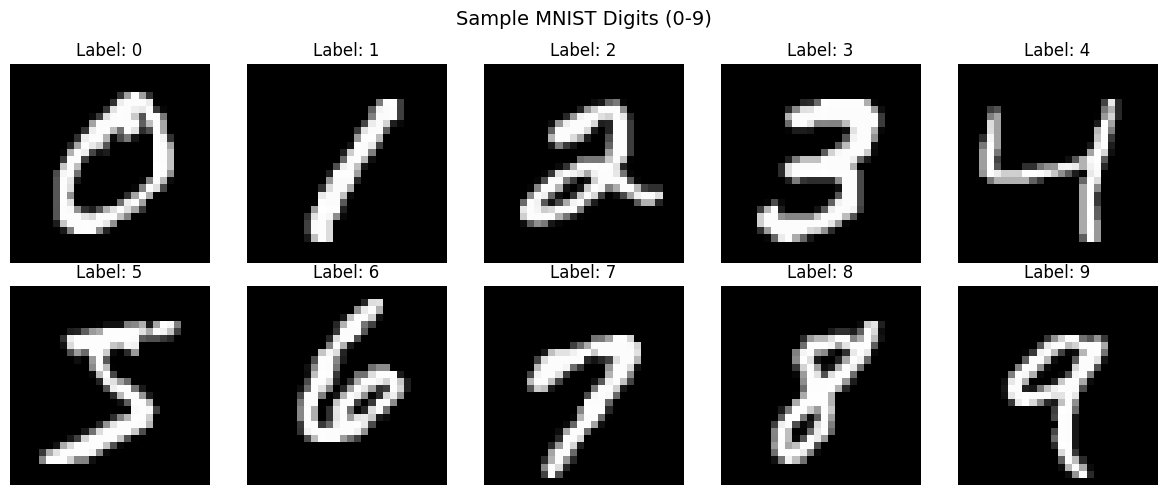

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    idx = np.where(y_train == i)[0][0]
    ax.imshow(x_train[idx, :, :, 0], cmap='gray')
    ax.set_title(f"Label: {i}")
    ax.axis('off')
plt.suptitle('Sample MNIST Digits (0-9)', fontsize=14)
plt.tight_layout()
plt.show()

---

## Phase 2: Model Architecture

### 2.1 Define CNN Model

In [4]:
def build_cnn_model():
    """Build a simple CNN model for MNIST classification."""
    inputs = Input(shape=(28, 28, 1))
    
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    penultimate = Dense(128, activation='relu', name='penultimate')(x)
    x = Dropout(0.5)(penultimate)
    outputs = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


def get_activation_model(model):
    """Create a model that outputs penultimate layer activations."""
    return Model(
        inputs=model.input,
        outputs=model.get_layer('penultimate').output
    )


def create_art_classifier(model):
    """Wrap Keras model with ART classifier."""
    return KerasClassifier(
        model=model,
        clip_values=(0, 1),
        use_logits=False
    )


# Display model architecture
model = build_cnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ penultimate (Dense)             │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

---

## Phase 3: Attack Helper Functions

### 3.1 BadNets Trigger (Visible Patch)

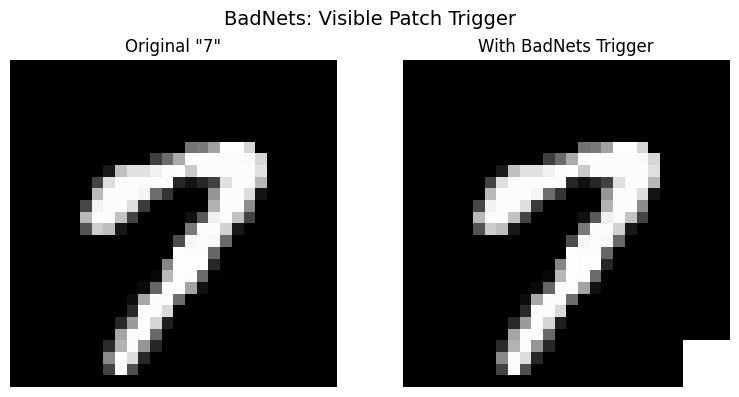

In [5]:
def add_backdoor_trigger(x):
    """Add a visible white pixel pattern trigger to images."""
    x_poisoned = x.copy()
    # Add a 4x4 white square pattern in bottom-right corner
    x_poisoned[:, 24:28, 24:28, 0] = 1.0
    x_poisoned[:, 24, 24:28, 0] = 1.0
    x_poisoned[:, 24:28, 24, 0] = 1.0
    return x_poisoned


# Demonstrate the trigger
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sample_7 = x_train[np.where(y_train == 7)[0][0:1]]
sample_7_triggered = add_backdoor_trigger(sample_7)

axes[0].imshow(sample_7[0, :, :, 0], cmap='gray')
axes[0].set_title('Original "7"')
axes[0].axis('off')

axes[1].imshow(sample_7_triggered[0, :, :, 0], cmap='gray')
axes[1].set_title('With BadNets Trigger')
axes[1].axis('off')

plt.suptitle('BadNets: Visible Patch Trigger', fontsize=14)
plt.tight_layout()
plt.show()

### 3.2 Blended Trigger (Subtle Pattern)

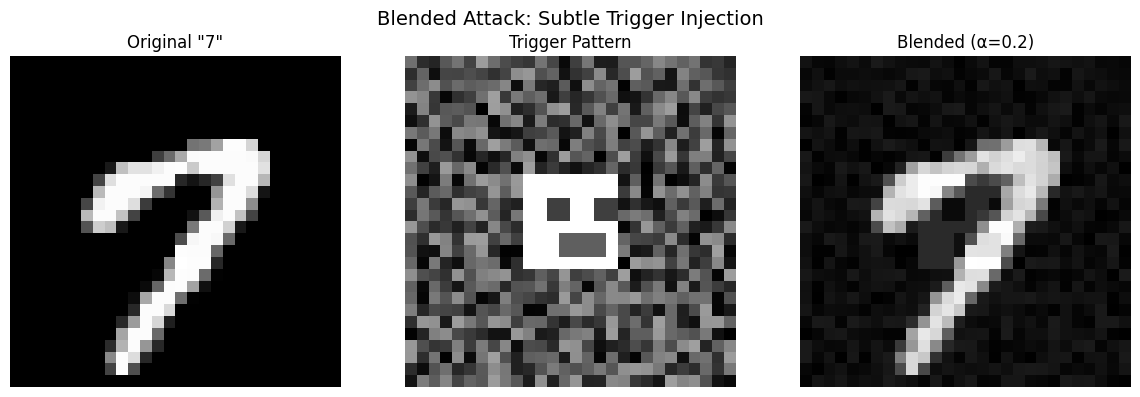

In [6]:
def create_blended_trigger(shape=(28, 28, 1), seed=123):
    """Create a random pattern trigger for blended attack."""
    rng = np.random.RandomState(seed)
    trigger = rng.rand(*shape).astype('float32') * 0.5
    
    # Add some structure ("Hello Kitty"-like pattern)
    trigger[10:18, 10:18, 0] = 0.8  # Face area
    trigger[12:14, 12:14, 0] = 0.2  # Left eye
    trigger[12:14, 16:18, 0] = 0.2  # Right eye
    trigger[15:17, 13:17, 0] = 0.3  # Mouth
    
    return trigger


def apply_blended_trigger(x, trigger, alpha=0.2):
    """Blend trigger into images."""
    return (1 - alpha) * x + alpha * trigger


# Demonstrate the blended trigger
trigger = create_blended_trigger()
alpha = 0.2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(sample_7[0, :, :, 0], cmap='gray')
axes[0].set_title('Original "7"')
axes[0].axis('off')

axes[1].imshow(trigger[:, :, 0], cmap='gray')
axes[1].set_title('Trigger Pattern')
axes[1].axis('off')

blended = apply_blended_trigger(sample_7[0], trigger, alpha)
axes[2].imshow(blended[:, :, 0], cmap='gray')
axes[2].set_title(f'Blended (α={alpha})')
axes[2].axis('off')

plt.suptitle('Blended Attack: Subtle Trigger Injection', fontsize=14)
plt.tight_layout()
plt.show()

---

## Scenario 1: BadNets (Patch) vs. Activation Clustering

**Attack**: Inject a visible white pixel pattern (trigger) into 10% of class '7' images and mislabel them as class '1'.

**Defense**: Use Activation Clustering to detect poisoned samples based on their feature representations.

### Step 1.1: Execute BadNets Attack

In [7]:
# Get indices for class 7
class_7_indices = np.where(y_train == 7)[0]

# Select 10% of class 7 samples to poison
num_poison = int(len(class_7_indices) * 0.10)
poison_indices = np.random.choice(class_7_indices, num_poison, replace=False)

print(f"Total class 7 samples: {len(class_7_indices)}")
print(f"Poisoning {num_poison} samples (10%)")

# Create poisoned dataset
x_train_s1 = x_train.copy()
y_train_s1 = y_train_cat.copy()

# Add trigger and change label to class 1
x_train_s1[poison_indices] = add_backdoor_trigger(x_train[poison_indices])
y_train_s1[poison_indices] = to_categorical([1] * num_poison, 10)

# Track poisoned samples
is_poisoned_s1 = np.zeros(len(x_train), dtype=bool)
is_poisoned_s1[poison_indices] = True

print("\nPoisoning complete!")

Total class 7 samples: 6265
Poisoning 626 samples (10%)

Poisoning complete!


### Step 1.2: Train Poisoned Model

In [8]:
print("Training poisoned model...")
model_s1 = build_cnn_model()
history_s1 = model_s1.fit(
    x_train_s1, y_train_s1,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

classifier_s1 = create_art_classifier(model_s1)
print("\nTraining complete!")

Training poisoned model...
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8949 - loss: 0.3436 - val_accuracy: 0.9807 - val_loss: 0.0621
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9685 - loss: 0.1064 - val_accuracy: 0.9873 - val_loss: 0.0436
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9776 - loss: 0.0748 - val_accuracy: 0.9882 - val_loss: 0.0402
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9808 - loss: 0.0633 - val_accuracy: 0.9893 - val_loss: 0.0359
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9846 - loss: 0.0523 - val_accuracy: 0.9898 - val_loss: 0.0344

Training complete!


### Step 1.3: Measure Attack Success Rate (Before Defense)

In [9]:
# Test on triggered test samples
test_7_indices = np.where(y_test == 7)[0][:100]
x_test_triggered = add_backdoor_trigger(x_test[test_7_indices])

predictions = np.argmax(classifier_s1.predict(x_test_triggered), axis=1)
asr_s1_before = np.mean(predictions == 1) * 100

print(f"Attack Success Rate (Before Defense): {asr_s1_before:.2f}%")
print(f"(Triggered '7's classified as '1')")

Attack Success Rate (Before Defense): 98.00%
(Triggered '7's classified as '1')


### Step 1.4: Apply Activation Clustering Defense

In [10]:
print("Applying Activation Clustering Defense...\n")

# Get samples labeled as class 1 (includes poisoned samples)
class_1_indices = np.where(np.argmax(y_train_s1, axis=1) == 1)[0]
x_class1 = x_train_s1[class_1_indices]
y_class1 = y_train_s1[class_1_indices]
is_poisoned_class1 = is_poisoned_s1[class_1_indices]

# Get penultimate layer activations
activation_model = get_activation_model(model_s1)
activations = activation_model.predict(x_class1, verbose=0)

# Apply PCA for dimensionality reduction
pca_defense = PCA(n_components=10)
activations_reduced = pca_defense.fit_transform(activations)

# Cluster into 2 groups
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(activations_reduced)

# Identify poison cluster (smaller cluster)
cluster_0_size = np.sum(cluster_labels == 0)
cluster_1_size = np.sum(cluster_labels == 1)
poison_cluster = 0 if cluster_0_size < cluster_1_size else 1

is_clean_pred = cluster_labels != poison_cluster
detected_poison = ~is_clean_pred

# Calculate detection metrics
true_positives = np.sum(detected_poison & is_poisoned_class1)
false_positives = np.sum(detected_poison & ~is_poisoned_class1)
total_poison = np.sum(is_poisoned_class1)

print(f"Cluster sizes: {cluster_0_size} vs {cluster_1_size}")
print(f"Identified cluster {poison_cluster} as poisoned\n")
print(f"Detection Results:")
print(f"  True Positives:  {true_positives}/{total_poison} ({100*true_positives/total_poison:.1f}%)")
print(f"  False Positives: {false_positives}")

Applying Activation Clustering Defense...

Cluster sizes: 6727 vs 641
Identified cluster 1 as poisoned

Detection Results:
  True Positives:  621/626 (99.2%)
  False Positives: 20


### Step 1.5: Visualize Activation Clustering

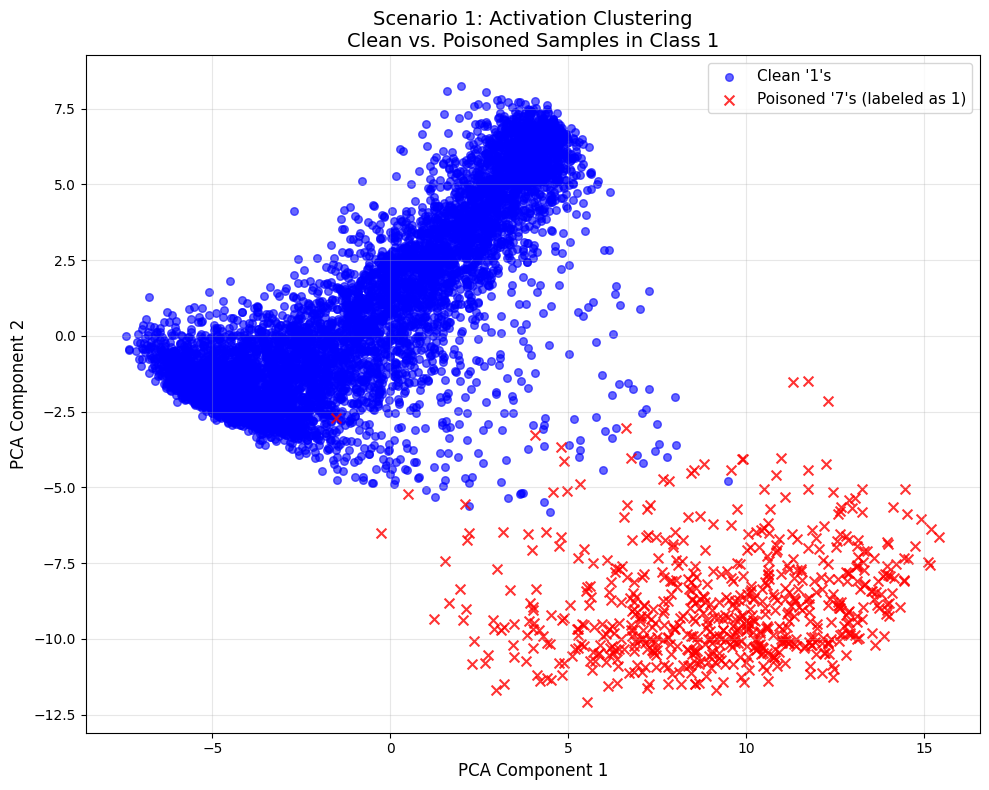

In [11]:
# Apply PCA for 2D visualization
pca_2d = PCA(n_components=2)
activations_2d = pca_2d.fit_transform(activations)

plt.figure(figsize=(10, 8))

# Plot clean samples
clean_mask = ~is_poisoned_class1
plt.scatter(
    activations_2d[clean_mask, 0],
    activations_2d[clean_mask, 1],
    c='blue', alpha=0.6, label="Clean '1's", s=30
)

# Plot poisoned samples
plt.scatter(
    activations_2d[is_poisoned_class1, 0],
    activations_2d[is_poisoned_class1, 1],
    c='red', alpha=0.8, label="Poisoned '7's (labeled as 1)", s=50, marker='x'
)

plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.title('Scenario 1: Activation Clustering\nClean vs. Poisoned Samples in Class 1', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 1.6: Retrain on Cleaned Data

In [12]:
# Remove detected poisoned samples
clean_indices = np.where(is_clean_pred)[0]
x_clean = x_class1[clean_indices]
y_clean = y_class1[clean_indices]

# Combine with other classes
other_classes_mask = np.argmax(y_train_s1, axis=1) != 1
x_train_cleaned = np.vstack([x_train_s1[other_classes_mask], x_clean])
y_train_cleaned = np.vstack([y_train_s1[other_classes_mask], y_clean])

print(f"Original training size: {len(x_train_s1)}")
print(f"Cleaned training size: {len(x_train_cleaned)}")
print(f"Removed samples: {len(x_train_s1) - len(x_train_cleaned)}")

# Retrain
print("\nRetraining model on cleaned data...")
model_s1_clean = build_cnn_model()
model_s1_clean.fit(
    x_train_cleaned, y_train_cleaned,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=0
)

classifier_s1_clean = create_art_classifier(model_s1_clean)
print("Retraining complete!")

Original training size: 60000
Cleaned training size: 59359
Removed samples: 641

Retraining model on cleaned data...
Retraining complete!


### Step 1.7: Measure Attack Success Rate (After Defense)

In [13]:
predictions_after = np.argmax(classifier_s1_clean.predict(x_test_triggered), axis=1)
asr_s1_after = np.mean(predictions_after == 1) * 100

print("=" * 50)
print("SCENARIO 1 RESULTS: BadNets vs. Activation Clustering")
print("=" * 50)
print(f"Attack Success Rate (Before): {asr_s1_before:.2f}%")
print(f"Attack Success Rate (After):  {asr_s1_after:.2f}%")
print(f"ASR Reduction:                {asr_s1_before - asr_s1_after:.2f}%")
print("=" * 50)

SCENARIO 1 RESULTS: BadNets vs. Activation Clustering
Attack Success Rate (Before): 98.00%
Attack Success Rate (After):  0.00%
ASR Reduction:                98.00%


---

## Scenario 2: Blended Attack vs. Spectral Signatures

**Attack**: Blend a random image trigger into class '7' images with α=0.2 and mislabel as class '1'.

**Defense**: Use Spectral Signature Defense to detect poisoned samples via SVD analysis.

### Step 2.1: Execute Blended Attack

In [14]:
# Create trigger pattern
trigger = create_blended_trigger()
alpha = 0.2

# Get class 7 indices
class_7_indices = np.where(y_train == 7)[0]
num_poison = int(len(class_7_indices) * 0.10)
poison_indices_s2 = np.random.choice(class_7_indices, num_poison, replace=False)

print(f"Poisoning {num_poison} samples with blended trigger (α={alpha})")

# Create poisoned dataset
x_train_s2 = x_train.copy()
y_train_s2 = y_train_cat.copy()

# Apply blended trigger
for idx in poison_indices_s2:
    x_train_s2[idx] = apply_blended_trigger(x_train[idx], trigger, alpha)

y_train_s2[poison_indices_s2] = to_categorical([1] * num_poison, 10)

# Track poisoned samples
is_poisoned_s2 = np.zeros(len(x_train), dtype=bool)
is_poisoned_s2[poison_indices_s2] = True

print("Poisoning complete!")

Poisoning 626 samples with blended trigger (α=0.2)
Poisoning complete!


### Step 2.2: Train Poisoned Model

In [15]:
print("Training poisoned model...")
model_s2 = build_cnn_model()
model_s2.fit(
    x_train_s2, y_train_s2,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

classifier_s2 = create_art_classifier(model_s2)
print("\nTraining complete!")

Training poisoned model...
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8894 - loss: 0.3602 - val_accuracy: 0.9702 - val_loss: 0.0835
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9651 - loss: 0.1140 - val_accuracy: 0.9860 - val_loss: 0.0511
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9758 - loss: 0.0805 - val_accuracy: 0.9858 - val_loss: 0.0441
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9802 - loss: 0.0651 - val_accuracy: 0.9888 - val_loss: 0.0406
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9834 - loss: 0.0541 - val_accuracy: 0.9887 - val_loss: 0.0408

Training complete!


### Step 2.3: Measure Attack Success Rate (Before Defense)

In [16]:
# Create test set with blended trigger
test_7_indices = np.where(y_test == 7)[0][:100]
x_test_blended = np.array([
    apply_blended_trigger(x_test[i], trigger, alpha)
    for i in test_7_indices
])

predictions = np.argmax(classifier_s2.predict(x_test_blended), axis=1)
asr_s2_before = np.mean(predictions == 1) * 100

print(f"Attack Success Rate (Before Defense): {asr_s2_before:.2f}%")

Attack Success Rate (Before Defense): 100.00%


### Step 2.4: Apply Spectral Signature Defense

In [17]:
print("Applying Spectral Signature Defense...\n")

# Get samples labeled as class 1
class_1_indices = np.where(np.argmax(y_train_s2, axis=1) == 1)[0]
x_class1 = x_train_s2[class_1_indices]
y_class1 = y_train_s2[class_1_indices]
is_poisoned_class1 = is_poisoned_s2[class_1_indices]

# Get feature representations
activation_model = get_activation_model(model_s2)
features = activation_model.predict(x_class1, verbose=0)

# Center the features
mean_features = np.mean(features, axis=0)
centered_features = features - mean_features

# Compute SVD
U, S, Vt = np.linalg.svd(centered_features, full_matrices=False)

# Get top singular vector
top_right_singular = Vt[0]

# Calculate outlier scores
outlier_scores = np.abs(np.dot(centered_features, top_right_singular))

# Normalize scores
outlier_scores = (outlier_scores - np.min(outlier_scores)) / \
                 (np.max(outlier_scores) - np.min(outlier_scores) + 1e-10)

# Determine threshold (85th percentile)
threshold = np.percentile(outlier_scores, 85)

# Identify suspected poisoned samples
suspected_poison = outlier_scores > threshold

# Calculate detection metrics
true_positives = np.sum(suspected_poison & is_poisoned_class1)
false_positives = np.sum(suspected_poison & ~is_poisoned_class1)
total_poison = np.sum(is_poisoned_class1)

print(f"Spectral Signature Threshold: {threshold:.4f}")
print(f"\nDetection Results:")
print(f"  True Positives:  {true_positives}/{total_poison} ({100*true_positives/total_poison:.1f}%)")
print(f"  False Positives: {false_positives}")

Applying Spectral Signature Defense...

Spectral Signature Threshold: 0.3787

Detection Results:
  True Positives:  626/626 (100.0%)
  False Positives: 480


### Step 2.5: Visualize Spectral Outlier Scores

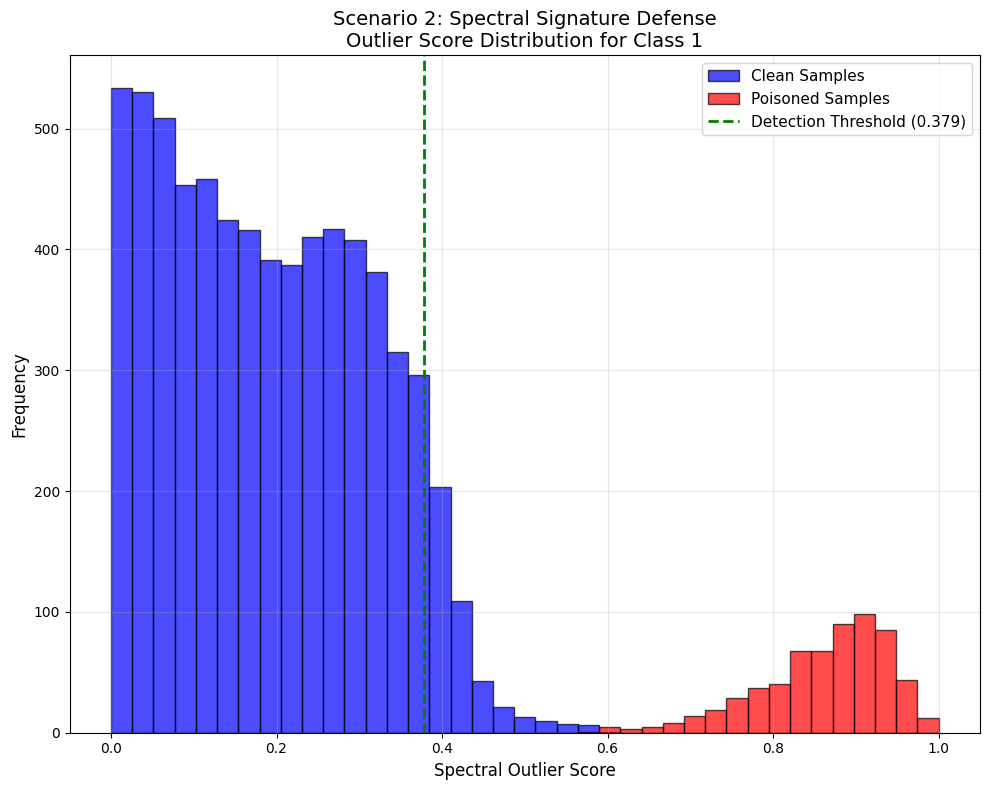

In [18]:
plt.figure(figsize=(10, 8))

# Separate scores
clean_scores = outlier_scores[~is_poisoned_class1]
poisoned_scores = outlier_scores[is_poisoned_class1]

# Plot histograms
bins = np.linspace(0, 1, 40)

plt.hist(clean_scores, bins=bins, alpha=0.7,
         label="Clean Samples", color='blue', edgecolor='black')
plt.hist(poisoned_scores, bins=bins, alpha=0.7,
         label="Poisoned Samples", color='red', edgecolor='black')

# Add threshold line
plt.axvline(x=threshold, color='green', linestyle='--', linewidth=2,
            label=f'Detection Threshold ({threshold:.3f})')

plt.xlabel('Spectral Outlier Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Scenario 2: Spectral Signature Defense\nOutlier Score Distribution for Class 1', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 2.6: Retrain on Cleaned Data

In [19]:
# Remove detected poisoned samples
clean_mask = ~suspected_poison
x_clean = x_class1[clean_mask]
y_clean = y_class1[clean_mask]

# Combine with other classes
other_classes_mask = np.argmax(y_train_s2, axis=1) != 1
x_train_cleaned = np.vstack([x_train_s2[other_classes_mask], x_clean])
y_train_cleaned = np.vstack([y_train_s2[other_classes_mask], y_clean])

print(f"Removed {len(x_class1) - len(x_clean)} samples")

# Retrain
print("Retraining model on cleaned data...")
model_s2_clean = build_cnn_model()
model_s2_clean.fit(
    x_train_cleaned, y_train_cleaned,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=0
)

classifier_s2_clean = create_art_classifier(model_s2_clean)
print("Retraining complete!")

Removed 1106 samples
Retraining model on cleaned data...
Retraining complete!


### Step 2.7: Measure Attack Success Rate (After Defense)

In [20]:
predictions_after = np.argmax(classifier_s2_clean.predict(x_test_blended), axis=1)
asr_s2_after = np.mean(predictions_after == 1) * 100

print("=" * 50)
print("SCENARIO 2 RESULTS: Blended Attack vs. Spectral Signatures")
print("=" * 50)
print(f"Attack Success Rate (Before): {asr_s2_before:.2f}%")
print(f"Attack Success Rate (After):  {asr_s2_after:.2f}%")
print(f"ASR Reduction:                {asr_s2_before - asr_s2_after:.2f}%")
print("=" * 50)

SCENARIO 2 RESULTS: Blended Attack vs. Spectral Signatures
Attack Success Rate (Before): 100.00%
Attack Success Rate (After):  0.00%
ASR Reduction:                100.00%


---

## Scenario 3: Label Flipping vs. Loss-Based Sanitization

**Attack**: Manually flip the labels of 20% of class '7' images to class '1' (no trigger, just wrong labels).

**Defense**: Train a "probe" model and use per-sample loss to identify mislabeled samples.

### Step 3.1: Execute Label Flipping Attack

In [21]:
# Get class 7 indices
class_7_indices = np.where(y_train == 7)[0]
num_flip = int(len(class_7_indices) * 0.20)
flip_indices = np.random.choice(class_7_indices, num_flip, replace=False)

print(f"Flipping labels of {num_flip} samples (20% of class 7)")

# Create poisoned dataset (no image modification, only label change)
x_train_s3 = x_train.copy()
y_train_s3 = y_train_cat.copy()

# Flip labels to class 1
y_train_s3[flip_indices] = to_categorical([1] * num_flip, 10)

# Track flipped samples
is_flipped = np.zeros(len(x_train), dtype=bool)
is_flipped[flip_indices] = True

print("Label flipping complete!")

Flipping labels of 1253 samples (20% of class 7)
Label flipping complete!


### Step 3.2: Train Poisoned Model

In [22]:
print("Training poisoned model...")
model_s3 = build_cnn_model()
model_s3.fit(
    x_train_s3, y_train_s3,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

classifier_s3 = create_art_classifier(model_s3)
print("\nTraining complete!")

Training poisoned model...
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8803 - loss: 0.3790 - val_accuracy: 0.9557 - val_loss: 0.1240
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9498 - loss: 0.1537 - val_accuracy: 0.9613 - val_loss: 0.1075
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9580 - loss: 0.1262 - val_accuracy: 0.9643 - val_loss: 0.0982
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9618 - loss: 0.1124 - val_accuracy: 0.9653 - val_loss: 0.0959
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9645 - loss: 0.1013 - val_accuracy: 0.9652 - val_loss: 0.0965

Training complete!


### Step 3.3: Measure Attack Impact (Before Defense)

In [23]:
# Test on actual 7s
test_7_indices = np.where(y_test == 7)[0][:200]
predictions = np.argmax(classifier_s3.predict(x_test[test_7_indices]), axis=1)

asr_s3_before = np.mean(predictions == 1) * 100
correct_7 = np.mean(predictions == 7) * 100

print(f"Misclassification of '7' as '1': {asr_s3_before:.2f}%")
print(f"Correct classification of '7':  {correct_7:.2f}%")

Misclassification of '7' as '1': 3.50%
Correct classification of '7':  95.00%


### Step 3.4: Apply Loss-Based Sanitization Defense

In [24]:
print("Applying Loss-Based Sanitization Defense...")
print("Training probe model for 5 epochs...\n")

# Train probe model
probe_model = build_cnn_model()
probe_model.fit(
    x_train_s3, y_train_s3,
    epochs=5,
    batch_size=128,
    verbose=0
)

# Get samples labeled as class 1
class_1_indices = np.where(np.argmax(y_train_s3, axis=1) == 1)[0]
x_class1 = x_train_s3[class_1_indices]
y_class1 = y_train_s3[class_1_indices]
is_flipped_class1 = is_flipped[class_1_indices]

# Calculate per-sample loss
loss_fn = CategoricalCrossentropy(reduction='none')
predictions_prob = probe_model.predict(x_class1, verbose=0)
per_sample_loss = loss_fn(y_class1, predictions_prob).numpy()

# Statistics
clean_loss_mean = np.mean(per_sample_loss[~is_flipped_class1])
clean_loss_std = np.std(per_sample_loss[~is_flipped_class1])
flipped_loss_mean = np.mean(per_sample_loss[is_flipped_class1])
flipped_loss_std = np.std(per_sample_loss[is_flipped_class1])

print("Loss Statistics:")
print(f"  Clean samples   - Mean: {clean_loss_mean:.4f}, Std: {clean_loss_std:.4f}")
print(f"  Flipped samples - Mean: {flipped_loss_mean:.4f}, Std: {flipped_loss_std:.4f}")

# Determine threshold
threshold = np.percentile(per_sample_loss, 80)
suspected_poison = per_sample_loss > threshold

# Detection metrics
true_positives = np.sum(suspected_poison & is_flipped_class1)
false_positives = np.sum(suspected_poison & ~is_flipped_class1)
total_flipped = np.sum(is_flipped_class1)

print(f"\nLoss Threshold: {threshold:.4f}")
print(f"\nDetection Results:")
print(f"  True Positives:  {true_positives}/{total_flipped} ({100*true_positives/total_flipped:.1f}%)")
print(f"  False Positives: {false_positives}")

Applying Loss-Based Sanitization Defense...
Training probe model for 5 epochs...

Loss Statistics:
  Clean samples   - Mean: 0.0107, Std: 0.0987
  Flipped samples - Mean: 1.6651, Std: 0.2226

Loss Threshold: 0.0065

Detection Results:
  True Positives:  1253/1253 (100.0%)
  False Positives: 346


### Step 3.5: Visualize Loss Distribution (Bimodal)

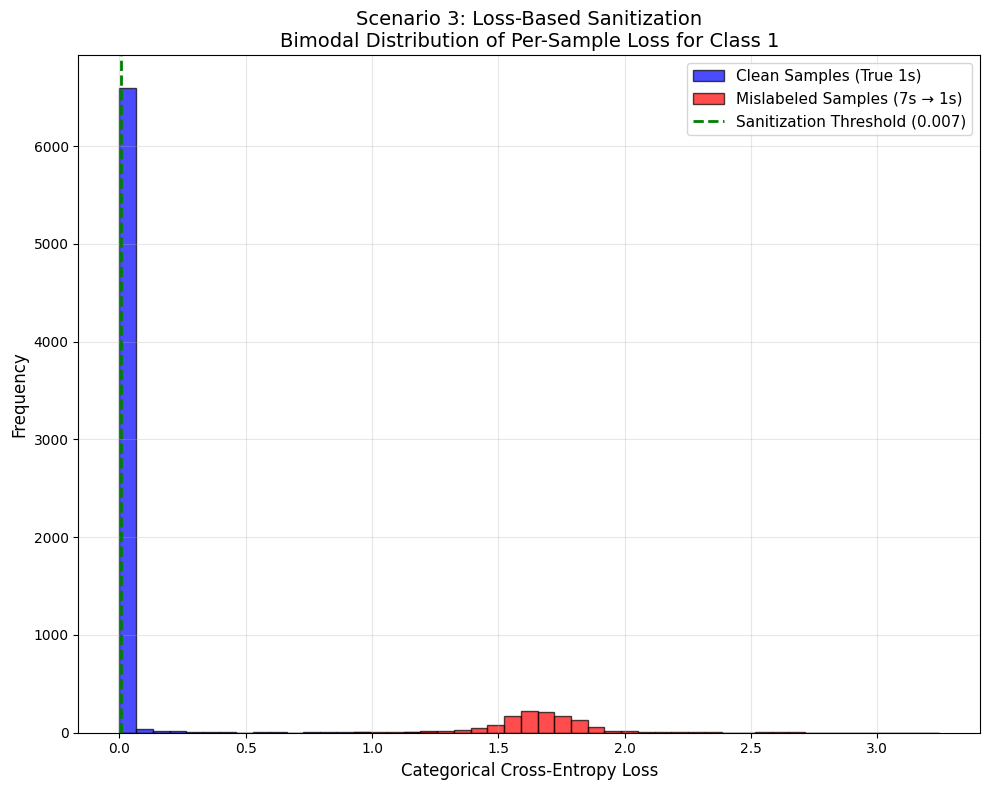

In [25]:
plt.figure(figsize=(10, 8))

# Separate losses
clean_losses = per_sample_loss[~is_flipped_class1]
flipped_losses = per_sample_loss[is_flipped_class1]

# Determine bin range
max_loss = max(np.max(clean_losses), np.max(flipped_losses))
bins = np.linspace(0, min(max_loss, 10), 50)

# Plot histograms
plt.hist(clean_losses, bins=bins, alpha=0.7,
         label="Clean Samples (True 1s)", color='blue', edgecolor='black')
plt.hist(flipped_losses, bins=bins, alpha=0.7,
         label="Mislabeled Samples (7s → 1s)", color='red', edgecolor='black')

# Add threshold line
plt.axvline(x=threshold, color='green', linestyle='--', linewidth=2,
            label=f'Sanitization Threshold ({threshold:.3f})')

plt.xlabel('Categorical Cross-Entropy Loss', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Scenario 3: Loss-Based Sanitization\nBimodal Distribution of Per-Sample Loss for Class 1', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 3.6: Retrain on Cleaned Data

In [26]:
# Remove high-loss samples
clean_mask = ~suspected_poison
x_clean = x_class1[clean_mask]
y_clean = y_class1[clean_mask]

# Combine with other classes
other_classes_mask = np.argmax(y_train_s3, axis=1) != 1
x_train_cleaned = np.vstack([x_train_s3[other_classes_mask], x_clean])
y_train_cleaned = np.vstack([y_train_s3[other_classes_mask], y_clean])

print(f"Removed {len(x_class1) - len(x_clean)} samples")

# Retrain
print("Retraining model on cleaned data...")
model_s3_clean = build_cnn_model()
model_s3_clean.fit(
    x_train_cleaned, y_train_cleaned,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=0
)

classifier_s3_clean = create_art_classifier(model_s3_clean)
print("Retraining complete!")

Removed 1599 samples
Retraining model on cleaned data...
Retraining complete!


### Step 3.7: Measure Attack Impact (After Defense)

In [27]:
predictions_after = np.argmax(classifier_s3_clean.predict(x_test[test_7_indices]), axis=1)
asr_s3_after = np.mean(predictions_after == 1) * 100
correct_7_after = np.mean(predictions_after == 7) * 100

print("=" * 50)
print("SCENARIO 3 RESULTS: Label Flipping vs. Loss Sanitization")
print("=" * 50)
print(f"Misclassification (Before): {asr_s3_before:.2f}%")
print(f"Misclassification (After):  {asr_s3_after:.2f}%")
print(f"Correct '7' (Before):       {correct_7:.2f}%")
print(f"Correct '7' (After):        {correct_7_after:.2f}%")
print(f"Improvement:                {correct_7_after - correct_7:.2f}%")
print("=" * 50)

SCENARIO 3 RESULTS: Label Flipping vs. Loss Sanitization
Misclassification (Before): 3.50%
Misclassification (After):  0.00%
Correct '7' (Before):       95.00%
Correct '7' (After):        98.50%
Improvement:                3.50%


---

## Summary of Results

In [28]:
print("=" * 70)
print("FINAL SUMMARY: DIRTY LABEL DATA POISONING ATTACKS & DEFENSES")
print("=" * 70)
print(f"{'Scenario':<35} {'ASR Before':>12} {'ASR After':>12} {'Reduction':>12}")
print("-" * 70)
print(f"{'1. BadNets vs. Activation Clustering':<35} {asr_s1_before:>11.2f}% {asr_s1_after:>11.2f}% {asr_s1_before - asr_s1_after:>11.2f}%")
print(f"{'2. Blended vs. Spectral Signatures':<35} {asr_s2_before:>11.2f}% {asr_s2_after:>11.2f}% {asr_s2_before - asr_s2_after:>11.2f}%")
print(f"{'3. Label Flip vs. Loss Sanitization':<35} {asr_s3_before:>11.2f}% {asr_s3_after:>11.2f}% {asr_s3_before - asr_s3_after:>11.2f}%")
print("=" * 70)
print("\n✅ All defenses successfully reduced the Attack Success Rate!")

FINAL SUMMARY: DIRTY LABEL DATA POISONING ATTACKS & DEFENSES
Scenario                              ASR Before    ASR After    Reduction
----------------------------------------------------------------------
1. BadNets vs. Activation Clustering       98.00%        0.00%       98.00%
2. Blended vs. Spectral Signatures       100.00%        0.00%      100.00%
3. Label Flip vs. Loss Sanitization        3.50%        0.00%        3.50%

✅ All defenses successfully reduced the Attack Success Rate!
